# Overview

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [136]:
df = pd.read_csv("..\data\cleaned.csv")

#drop row if pager_code == training
df = df[df.pager_code != 'Training']


# Date analysis

In [130]:
# number of callouts in a given year /quarter.

In [131]:
# what is the range in dates
print(dft['date_of_shout'].min())
print(df['date_of_shout'].max())

01/05/2022
31/12/2021


In [32]:
# Convert to datetime
df['date_of_shout'] = pd.to_datetime(df['date_of_shout'])
df['quarter'] = df['date_of_shout'].dt.quarter
df['year'] = df['date_of_shout'].dt.year
dfttt[['date_of_shout','quarter','year']].head()

,date_of_shout,quarter,year
0,2023-07-21,3,2023
1,2023-07-19,3,2023
2,2023-07-16,3,2023
3,2023-07-08,3,2023
4,2023-07-05,3,2023


In [37]:
# Define function to count codes separately
def count_codes_222(series):
    return (series == 222).sum()

def count_codes_333(series):
    return (series == 333).sum()

def count_codes_999(series):
    return (series == 999).sum()

# Group by year and quarter and count codes separately
df_grouped = df.groupby(['year', 'quarter'])
counts_222 = df_grouped['pager_code'].apply(count_codes_222).reset_index(name='count_222')
counts_333 = df_grouped['pager_code'].apply(count_codes_333).reset_index(name='count_333')
counts_999 = df_grouped['pager_code'].apply(count_codes_999).reset_index(name='count_999')

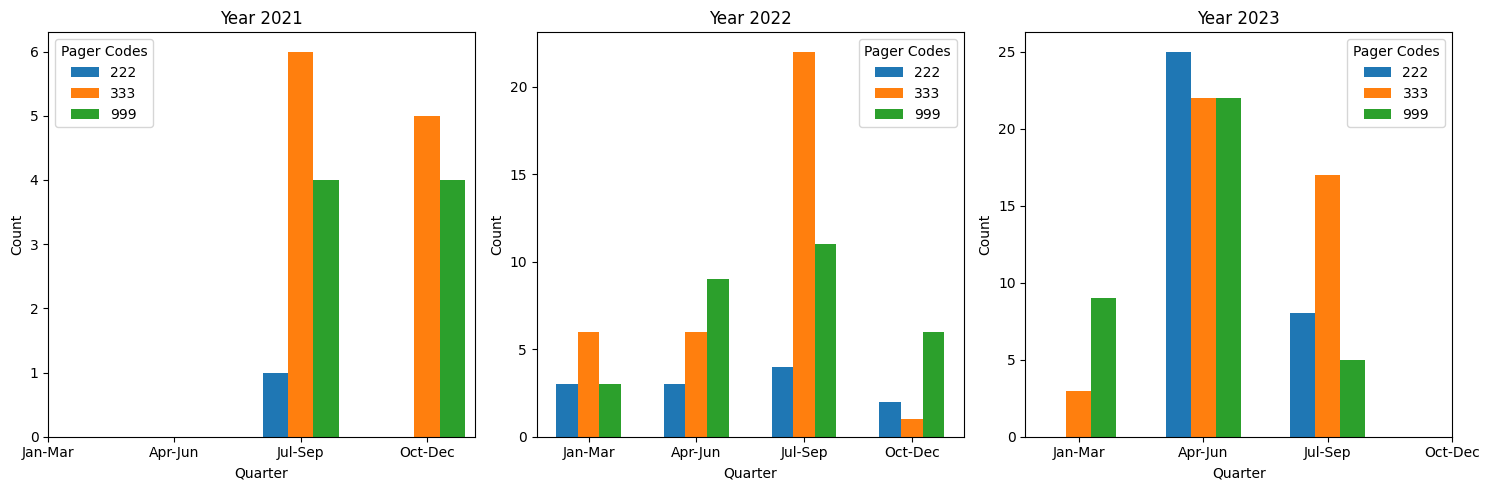

In [39]:
# Define a mapping for quarters
quarter_labels = {
    1: 'Jan-Mar',
    2: 'Apr-Jun',
    3: 'Jul-Sep',
    4: 'Oct-Dec'
}

color_mapping = {222: 'yellow', 333: 'green', 999: 'red'}


# Plotting all graphs together
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for idx, year in enumerate(counts_222['year'].unique()):
    df_year_222 = counts_222[counts_222['year'] == year]
    df_year_333 = counts_333[counts_333['year'] == year]
    df_year_999 = counts_999[counts_999['year'] == year]
    
    ax = axes[idx]
    ax.bar(df_year_222['quarter'] - 0.2, df_year_222['count_222'], width=0.2, label='222')
    ax.bar(df_year_333['quarter'], df_year_333['count_333'], width=0.2, label='333')
    ax.bar(df_year_999['quarter'] + 0.2, df_year_999['count_999'], width=0.2, label='999')
    
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Quarter')
    ax.set_ylabel('Count')
    ax.legend(title='Pager Codes')
    ax.set_xticks(range(1, 5))
    ax.set_xticklabels([quarter_labels[q] for q in range(1, 5)])

plt.tight_layout()
plt.show()



# Time analysis


For each person what are their callout time distributions? (or those with a significant number of incidents atteneded).

In [138]:
feats=['time_of_shout','time_boat_launched','time_boat_returned']
# dft=df[feats]
# As a placeholder for missing values we entered "00:00" in for time features
#We replace them with NaN

# Replace "00:00" with NaN
df['time_of_shout'] = df['time_of_shout'].replace("00:00", np.nan)
df['time_boat_launched'] = df['time_boat_launched'].replace("00:00", np.nan)
df['time_boat_returned'] = df['time_boat_returned'].replace("00:00", np.nan)

# Display the DataFrame
print(df[feats].head(88))

   time_of_shout time_boat_launched time_boat_returned
0          15:05              15:20              16:15
1          18:44              19:00              20:15
2          11:10              11:10              12:15
3          09:44              09:55              10:30
4          18:49              19:04              20:04
..           ...                ...                ...
83         22:00                NaN              23:20
84         20:45              21:00              23:15
85         19:15              19:25              21:00
86         13:15                NaN                NaN
87         19:26              19:35              20:05

[88 rows x 3 columns]


In [139]:
# Convert time columns to datetime format
df['time_of_shout'] = pd.to_datetime(df['time_of_shout'], format='%H:%M')
df['time_boat_launched'] = pd.to_datetime(df['time_boat_launched'], format='%H:%M')
df['time_boat_returned'] = pd.to_datetime(df['time_boat_returned'], format='%H:%M')

# Define a function to calculate time difference considering crossing midnight
def time_difference(start, end):
    if start <= end:
        return (end - start).total_seconds() / 60
    else:
        midnight = pd.Timestamp(end.date()) + pd.Timedelta(days=1)
        return (midnight - start).total_seconds() / 60 + (end - pd.Timestamp(end.date())).total_seconds() / 60

# Determine time between "time_of_shout" and "time_boat_launched" if values are not NaN
df['shout_launch_time'] = df.apply(
    lambda row: time_difference(row['time_of_shout'], row['time_boat_launched'])
    if pd.notnull(row['time_of_shout']) and pd.notnull(row['time_boat_launched']) else np.nan, axis=1)

# Determine time between "time_boat_launched" and "time_boat_returned" if values are not NaN
df['launch_return_time'] = df.apply(
    lambda row: time_difference(row['time_boat_launched'], row['time_boat_returned'])
    if pd.notnull(row['time_boat_launched']) and pd.notnull(row['time_boat_returned']) else np.nan, axis=1)


# Determine the shout_to_return_time if values are not NaN
df['shout_to_return_time'] = df.apply(
    lambda row: time_difference(row['time_of_shout'], row['time_boat_returned'])
    if pd.notnull(row['time_of_shout']) and pd.notnull(row['time_boat_returned']) else np.nan, axis=1)

In [140]:
feats_more=feats+["shout_launch_time",'launch_return_time','shout_to_return_time']
df['time_of_shout'] = df['time_of_shout'].dt.time
df['time_boat_launched'] = df['time_boat_launched'].dt.time
df['time_boat_returned'] = df['time_boat_returned'].dt.time
print(df[feats_more].head(88))

   time_of_shout time_boat_launched time_boat_returned  shout_launch_time  \
0       15:05:00           15:20:00           16:15:00               15.0   
1       18:44:00           19:00:00           20:15:00               16.0   
2       11:10:00           11:10:00           12:15:00                0.0   
3       09:44:00           09:55:00           10:30:00               11.0   
4       18:49:00           19:04:00           20:04:00               15.0   
..           ...                ...                ...                ...   
83      22:00:00                NaT           23:20:00                NaN   
84      20:45:00           21:00:00           23:15:00               15.0   
85      19:15:00           19:25:00           21:00:00               10.0   
86      13:15:00                NaT                NaT                NaN   
87      19:26:00           19:35:00           20:05:00                9.0   

    launch_return_time  shout_to_return_time  
0                 55.0      

In [141]:
# check if any shout_launch_time  or launch_return_time   are negative
# print(df[df['shout_launch_time'] < 0]) #none
# print(df[df['launch_return_time'] < 0])# none

#count the number of rows which have no nan in either shout_launch_time or launch_return_time
# df.shape[0]#207
# print(df.dropna(subset=[ 'launch_return_time']).shape[0]) #183
# print(df.dropna(subset=['shout_launch_time']).shape[0]) #201

#drop rows with nan in either shout_launch_time or launch_return_time
dft=df.copy()
dft = dft.dropna(subset=['shout_launch_time', 'launch_return_time','shout_to_return_time'])
print(dft.shape[0]) #183

183


In [142]:
feats=['pager_code','time_of_shout','time_boat_launched','time_boat_returned',"shout_launch_time","launch_return_time","shout_to_return_time"]
dft[feats].head()

,pager_code,time_of_shout,time_boat_launched,time_boat_returned,shout_launch_time,launch_return_time,shout_to_return_time
0,999,15:05:00,15:20:00,16:15:00,15.0,55.0,70.0
1,333,18:44:00,19:00:00,20:15:00,16.0,75.0,91.0
2,999,11:10:00,11:10:00,12:15:00,0.0,65.0,65.0
3,333,09:44:00,09:55:00,10:30:00,11.0,35.0,46.0
4,222,18:49:00,19:04:00,20:04:00,15.0,60.0,75.0


Given the following I want for for each feature a boxplot for pager_code 222,333,999

Why did we have these time outliers?

In [210]:
dftpager_outliers = dft[(dft['shout_launch_time'] > 60) | 
                        (dft['launch_return_time'] > 400) | 
                        (dft['shout_to_return_time'] > 300)]
# dftpager_outliers.shape[0] #8

In [211]:
x=dftpager_outliers[['time_of_shout','time_boat_launched','time_boat_returned']+feats+["shout_details"]]
print(x.to_string(index=False))  # print full line


time_of_shout time_boat_launched time_boat_returned  pager_code  shout_launch_time  launch_return_time  shout_to_return_time                                                                                                                                                                                                                                                   shout_details
     19:15:00           19:08:00           21:15:00         222             1433.0               127.0                 120.0                                             Crew were out on training when flagged down by a member of the public to a bROken down ski south of duck bay marina with 1 person on board. Crew then secured the Jetski and towed it back to Duncan mills slipway.
     12:02:00           10:30:00           13:35:00         999             1348.0               185.0                  93.0    Crew made aware of two persons fallen into the water fROm a small vessel near to Duncan mill’s slipway. Both h

In [ ]:
We have outliers as the crew have recorded a train exercise and an incident at the same time. What they could have done was to note when the training finished/incident started and logged these as two separate events.

Recommend keep separate training and incidents.

for some reason the time of launch is before the time of shout.

I am working under the assumptiong that the time_of_shout is before time_boat_launch.


In [208]:
# Filter out outliers
dftpager = dft[(dft['shout_launch_time'] <= 60) & 
               (dft['launch_return_time'] <= 400) & 
               (dft['shout_to_return_time'] <= 300)]

# Melt the DataFrame to long format for boxplot
dftpager = dftpager.melt(id_vars='pager_code', var_name='feature', value_name='time')

# Select the features to plot
feats = ['pager_code', 'shout_launch_time', 'launch_return_time', 'shout_to_return_time']

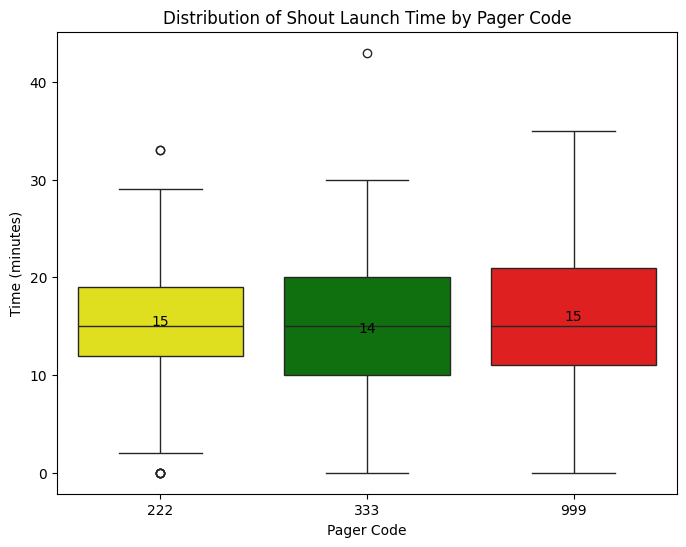

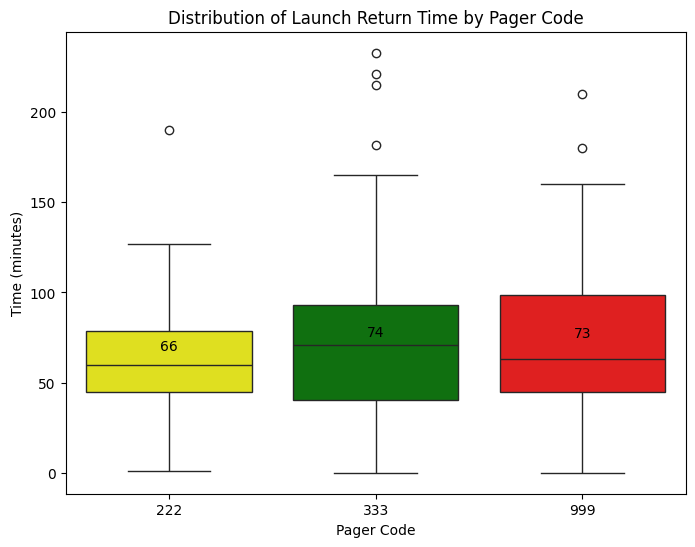

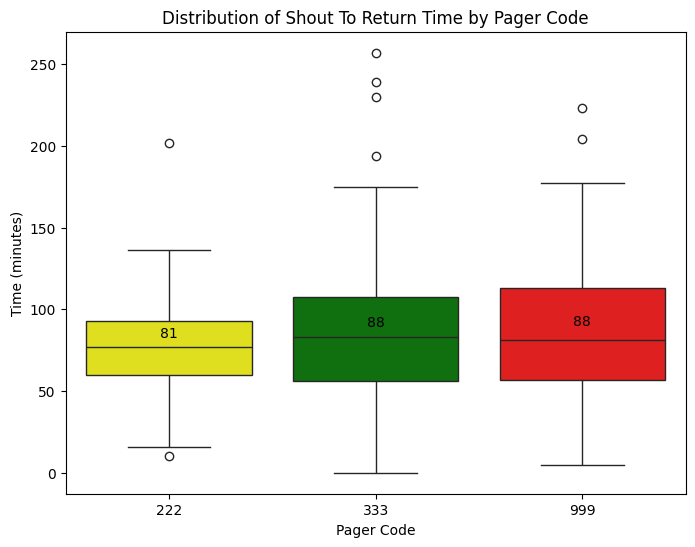

In [222]:
# Define color mapping for specific pager codes
color_mapping = {222: 'yellow', 333: 'green', 999: 'red'}

# Iterate over each feature and create a separate boxplot
for feat in feats[1:]:
    plt.figure(figsize=(8, 6))
    
    # Filter the DataFrame for the current feature
    filtered_data = dftpager[dftpager['feature'] == feat]
    
    # Extract unique pager codes and assign colors based on the mapping
    unique_pager_codes = filtered_data['pager_code'].unique()
    colors = [color_mapping.get(code, 'blue') for code in unique_pager_codes]
    
    # Boxplot with custom colors
    sns.boxplot(x='pager_code', y='time', hue='pager_code', data=filtered_data, palette=color_mapping, dodge=False)

    # Hide the legend
    plt.legend([],[], frameon=False)    
    
    # Extract the mean for each pager_code
    mean_values = filtered_data.groupby('pager_code')['time'].mean()
    
    # Annotate boxplot with mean values
    for i, mean in enumerate(mean_values):
        plt.text(i, mean, f'{round(mean)}', ha='center', va='bottom', color='black', fontsize=10)
    
    plt.xlabel('Pager Code')
    plt.ylabel('Time (minutes)')
    plt.title(f'Distribution of {feat.replace("_", " ").title()} by Pager Code')
    plt.show()


In [228]:
# How many incidents have each crew memember attended?
dft.shape[0]

crew={
    "RB": "Ronnie Britton",
    "RO": "Rennie Oliver",
    "IG": "Iain Gollan (Goz)",
    "AM": "Ally McLeod",
    "ABS": "Andy Biddulph Snr",
    "ABJ": "Andy Biddulph Jnr",
    "GD": "Gemma Dorran",
    "PBT": "Phils Brooks-Taylor",
    "DON": "David O'Neil",
    "CC": "Craig Clancy",
    "GH": "Gerry Heaney",
    "AJM": "Angus John MacDonald",
    "CMS": "Callum MacKenzie Stevens",
    "DS": "David Stuart",
    "TR": "Thomas Rogers",
    "EM": "Euan MciIwraith",
    "PD": "Paul Dorrian",
    "KM": "Kevin McPartland",
    "JB": "Jenna Biddulph",
    "VM": "Vicki Murphy",
    "JM": "John Mason",
    "AC": "Andy Connell",
    "FN": "Franny Nicol",
    "FR": "Frank Rogers",
    "CA": "Christine Allan",
    "CS": "Clinton Salter",
    "JT": "James Thomson",
    "TAM":"Tam (Cox)",
    "GERARD":"Gerard",
    "DAVY":"Davy",
    "LEE":"Lee",
}


In [229]:

crew.keys()

dict_keys(['RB', 'RO', 'IG', 'AM', 'ABS', 'ABJ', 'GD', 'PBT', 'DON', 'CC', 'GH', 'AJM', 'CMS', 'DS', 'TR', 'EM', 'PD', 'KM', 'JB', 'VM', 'JM', 'AC', 'FN', 'FR', 'CA', 'CS', 'JT', 'TAM', 'GERARD', 'DAVY', 'LEE'])

In [ ]:

# ['date_of_shout', 'crew_on_board','crew_on_shore']

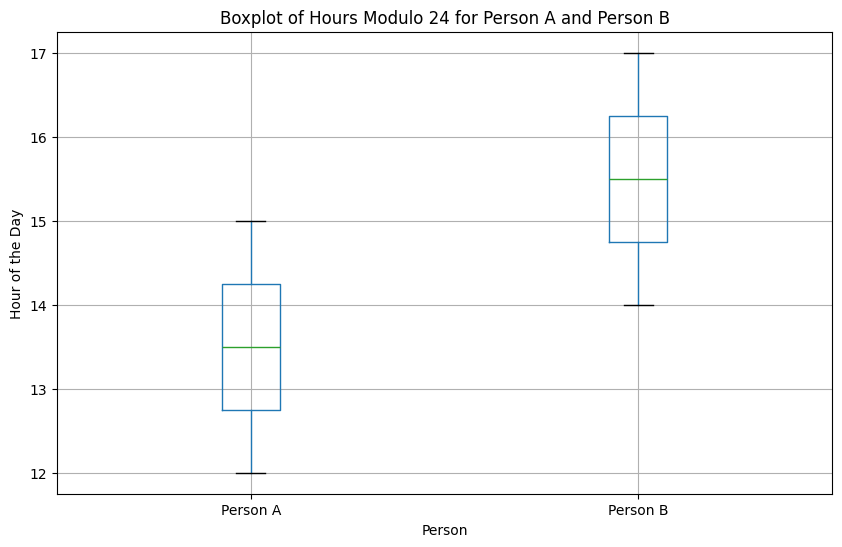

In [ ]:
# from df (full) remove only those without time of shout.

# Given times for Person A
times_a = ['14:30', '12:45', '15:05', '13:56']

# Convert times to datetime objects for Person A
time_objects_a = [pd.to_datetime(time, format='%H:%M') for time in times_a]

# Extract hour component modulo 24 for Person A
hours_mod_24_a = [time.hour % 24 for time in time_objects_a]

# Given times for Person B (one hour later)
times_b = ['15:30', '13:45', '16:05', '14:56']

# Convert times to datetime objects for Person B
time_objects_b = [pd.to_datetime(time, format='%H:%M') for time in times_b]

# Extract hour component modulo 24 for Person B
hours_mod_24_b = [(time.hour + 1) % 24 for time in time_objects_b]  # Adding 1 hour for Person B

# Create DataFrame for both persons
df = pd.DataFrame({'Person A': hours_mod_24_a, 'Person B': hours_mod_24_b})

# Plot boxplot for both persons
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(ax=ax)

# Set labels and title
ax.set_xlabel('Person')
ax.set_ylabel('Hour of the Day')
ax.set_title('Boxplot of Hours Modulo 24 for Person A and Person B')

# Show plot
plt.show()



## Pager codes and length of time taken


In [ ]:



# Define the time range from 06:00 to 23:59
start_time = 6 * 60  # 06:00 in minutes
end_time = 23 * 60 + 59  # 23:59 in minutes

# Generate random data points within the time range
num_points = 40
np.random.seed(0)  # For reproducibility
data_point_times = np.random.uniform(start_time, end_time, num_points)
data_point_durations = np.random.randint(60, 180, num_points)  # Random durations between 60 and 180 minutes

# Plotting the line marking the time range
plt.axvline(x=start_time, color='gray', linestyle='--')
plt.axvline(x=end_time, color='gray', linestyle='--')

# Plotting the data points as bars
for time, duration in zip(data_point_times, data_point_durations):
    plt.bar(time, duration, color='red', width=10)  # Adjust width as needed

# Adding labels and title
plt.xlabel('Time (hours)')
plt.ylabel('Duration (minutes)')
plt.title('Data Points within Time Range')

# Setting x-axis limits
plt.xlim(start_time, end_time)

# Display the plot
plt.show()


## Pager and times begun (boxplot)

## length of time and top 10 incidents? 



# Crew analysis



## crew appearances (numbers)

In [5]:
df.columns
feats=['date_of_shout','time_of_shout','time_boat_returned',
'pager_code',
'shout_details_tags',
'crew_on_board',
'crew_on_shore',
]



Index(['date_of_shout', 'time_of_shout', 'time_boat_launched', 'pager_code',
       'what_three_words', 'location_of_shout', 'Unnamed: 6', 'core_long_lat',
       'adjustment_km', 'adj_long_lat', 'shout_details', 'shout_details_tags',
       'crew_on_board', 'crew_on_shore', 'weather_at_time_of_shout'],
      dtype='object')

In [ ]:
coxswains=["RB","RO","IG","AM","ABS"]
satfy_advisors=["ABS","DON"]

# Example data as a list of comma-separated strings
data = ['AB,CD,EF', 'GH,IJ,KL', 'AB,CD,XY', 'AB,XY,CD', 'EF,CD,AB']
df["crew"]

def counter(given_initials, data):
    # Count the number of occurrences of the given set of initials
    dict={"999":0,"333":0,"222":0}
    count = 0
    for entry in data:
        if given_initials in entry:
            count += 1

    return dict

In [ ]:

#example
counter("RB", data)



## Crew and pager codes (partitioned bar graph - number of incidents attended)



In [ ]:
import matplotlib.pyplot as plt

# Data for the bar graph
categories = ['Category A', 'Category B', 'Category C']
values_part1 = [10, 15, 20]  # Values for part 1 of each category
values_part2 = [5, 10, 15]    # Values for part 2 of each category

# Colors for each part
colors_part1 = ['blue', 'green', 'red']
colors_part2 = ['lightblue', 'lightgreen', 'lightcoral']

# Plotting the bar graph
plt.figure(figsize=(8, 6))

plt.bar(categories, values_part1, color=colors_part1, label='Part 1')
plt.bar(categories, values_part2, color=colors_part2, label='Part 2', bottom=values_part1)

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Graph Decomposed into Parts')
plt.legend()

# Display the plot
plt.show()

import pandas as pd

# Example data
data = {
    'Initials': ['AB,CD,EF', 'GH,IJ,KL', 'AB,CD,XY', 'AB,XY,CD', 'EF,CD,AB'],
    'Pager': [999, 333, 222, 999, 222]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Given set of initials to search for
given_initials = 'AB'

# Group by initials and collect pagers
grouped = df.groupby('Initials')['Pager'].apply(list).reset_index()

# Filter the DataFrame to get the pagers for the given set of initials
pagers = grouped[grouped['Initials'].str.contains(given_initials)]['Pager'].tolist()

print(f"The pagers for the given set of initials '{given_initials}' are:")
for pager_list in pagers:
    print(pager_list)


## Coxwains and who would be best to train next - experience




# Pager 



## (number of incidents in a date range) (spring/summer/autum/winter(barplot)


# shout tags


## shout tags - dates?

## shout tags and time taken.




